In [7]:
!python -m spacy download fr_core_news_sm

[+] Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


You should consider upgrading via the 'C:\Users\user\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter


def preprocessing(french_tokenizer, englisg_tokenizer):
    en_counter, fr_counter = Counter(), Counter()
    
    english, french = [], []
    for text_data in text_datas:
        en, fr = text_data.strip('\n').split('\t')
        en_tokens, fr_tokens = englisg_tokenizer(en), french_tokenizer(fr)

        english.append(en_tokens)
        french.append(fr_tokens)
        
        en_counter.update(en_tokens)
        fr_counter.update(fr_tokens)

    return en_counter, fr_counter, english, french

# 讀檔
with open('data/eng-fra.txt', 'r',encoding='utf-8') as f:
    text_datas = f.readlines()
    
# 建立標記器
french_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
englisg_tokenizer = get_tokenizer('basic_english')

en_counter, fr_counter, english, french = preprocessing(french_tokenizer, englisg_tokenizer)

# 建立詞彙表
en_vocab = vocab(en_counter, min_freq=5, specials=('<PAD>', '<SOS>','<EOS>','<UNK>'))
en_vocab.set_default_index(en_vocab.get_stoi()['<UNK>'])

fr_vocab = vocab(fr_counter, min_freq=5, specials=('<PAD>', '<SOS>','<EOS>','<UNK>'))
fr_vocab.set_default_index(en_vocab.get_stoi()['<UNK>'])

# Ecoder與Decoder的Embedding輸入大小
INPUT_DIM =  len(en_vocab)
OUTPUT_DIM = len(fr_vocab)

# 取得給予模型的索引值
SOS_IDX = en_vocab.get_stoi()['<SOS>']
EOS_IDX = en_vocab.get_stoi()['<EOS>']
PAD_IDX = en_vocab.get_stoi()['<PAD>']

In [2]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch

class TranslateDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)

english_num, french_num = [], []
for i in range(len(english)):
    en_num = en_vocab.lookup_indices(english[i]) + [EOS_IDX]
    fr_num = fr_vocab.lookup_indices(french[i])  + [EOS_IDX]

    english_num.append(torch.tensor(en_num))
    french_num.append(torch.tensor(fr_num))

all_seq = english_num + french_num
pad_seq = pad_sequence(all_seq, padding_value=PAD_IDX, batch_first=True)

english_num, french_num = pad_seq[:len(english_num)], pad_seq[len(english_num):]
MAX_LEN = len(english_num[0])

x_train, x_valid, y_train, y_valid = train_test_split(english_num, french_num, train_size=0.8, random_state=46, shuffle=False)

trainset = TranslateDataset(x_train, y_train)
validset = TranslateDataset(x_valid, y_valid)


train_loader = DataLoader(trainset, batch_size = 1024, shuffle = True, num_workers = 0, pin_memory = True)
valid_loader = DataLoader(validset, batch_size = 1024, shuffle = True, num_workers = 0, pin_memory = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch.nn as nn
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD_IDX)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
    
encoder = EncoderRNN(input_size = INPUT_DIM, hidden_size = 128).to(device)

In [4]:
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_IDX)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LEN):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
    
decoder = AttnDecoderRNN(hidden_size = 128, output_size = OUTPUT_DIM).to(device)

In [5]:
import torch.optim as optim
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-3)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt 

def train(epoch):
    train_loss = 0
    train_pbar = tqdm(train_loader, position=0, leave=True) 

    encoder.train()
    decoder.train()
    for input_datas in train_pbar: 
        
        inputs, targets = [i.to(device) for i in input_datas]
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
       
        encoder_outputs, encoder_hidden = encoder(inputs)

        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, targets)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            targets.view(-1)
        )

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        train_pbar.set_description(f'Train Epoch {epoch}')  
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) 

        train_loss += loss.item()

    return train_loss/len(train_loader)

def valid(epoch):
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True) 

    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar: 
            
            inputs, targets = [i.to(device) for i in input_datas]
         
            encoder_outputs, encoder_hidden = encoder(inputs)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, targets)
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                targets.view(-1)
            )
    
        
    
            valid_pbar.set_description(f'Valid Epoch {epoch}')  
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'}) 
    
            valid_loss += loss.item()
    
        return valid_loss/len(valid_loader)

def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.67it/s, loss=1.232]


Saving Model With Loss 1.24677
Train Loss: 1.76774| Valid Loss: 1.24677| Best Loss: 1.24677



Valid Epoch 1: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.02it/s, loss=1.163]


Saving Model With Loss 1.16585
Train Loss: 0.64946| Valid Loss: 1.16585| Best Loss: 1.16585



Valid Epoch 2: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.62it/s, loss=1.111]


Saving Model With Loss 1.09640
Train Loss: 0.59262| Valid Loss: 1.09640| Best Loss: 1.09640



Valid Epoch 3: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.07it/s, loss=1.015]


Saving Model With Loss 1.02976
Train Loss: 0.54499| Valid Loss: 1.02976| Best Loss: 1.02976



Valid Epoch 4: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.84it/s, loss=1.007]


Saving Model With Loss 0.98539
Train Loss: 0.50927| Valid Loss: 0.98539| Best Loss: 0.98539



Valid Epoch 5: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.94it/s, loss=0.955]


Saving Model With Loss 0.95329
Train Loss: 0.48364| Valid Loss: 0.95329| Best Loss: 0.95329



Valid Epoch 6: 100%|███████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99it/s, loss=0.930]


Saving Model With Loss 0.92508
Train Loss: 0.46251| Valid Loss: 0.92508| Best Loss: 0.92508



Valid Epoch 7: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.00it/s, loss=0.905]


Saving Model With Loss 0.90406
Train Loss: 0.44504| Valid Loss: 0.90406| Best Loss: 0.90406



Valid Epoch 8: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.874]


Saving Model With Loss 0.88532
Train Loss: 0.43024| Valid Loss: 0.88532| Best Loss: 0.88532



Valid Epoch 9: 100%|███████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.887]


Saving Model With Loss 0.87167
Train Loss: 0.41566| Valid Loss: 0.87167| Best Loss: 0.87167



Valid Epoch 10: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.01it/s, loss=0.840]


Saving Model With Loss 0.85344
Train Loss: 0.40274| Valid Loss: 0.85344| Best Loss: 0.85344



Valid Epoch 11: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.98it/s, loss=0.852]


Saving Model With Loss 0.83914
Train Loss: 0.39103| Valid Loss: 0.83914| Best Loss: 0.83914



Valid Epoch 12: 100%|██████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99it/s, loss=0.807]


Saving Model With Loss 0.82779
Train Loss: 0.37945| Valid Loss: 0.82779| Best Loss: 0.82779



Valid Epoch 13: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.813]


Saving Model With Loss 0.81330
Train Loss: 0.36816| Valid Loss: 0.81330| Best Loss: 0.81330



Valid Epoch 14: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.92it/s, loss=0.783]


Saving Model With Loss 0.80397
Train Loss: 0.35739| Valid Loss: 0.80397| Best Loss: 0.80397



Valid Epoch 15: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.95it/s, loss=0.785]


Saving Model With Loss 0.79492
Train Loss: 0.34747| Valid Loss: 0.79492| Best Loss: 0.79492



Valid Epoch 16: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.95it/s, loss=0.796]


Saving Model With Loss 0.78299
Train Loss: 0.33827| Valid Loss: 0.78299| Best Loss: 0.78299



Valid Epoch 17: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.00it/s, loss=0.762]


Saving Model With Loss 0.77473
Train Loss: 0.32935| Valid Loss: 0.77473| Best Loss: 0.77473



Valid Epoch 18: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.762]


Saving Model With Loss 0.76645
Train Loss: 0.32137| Valid Loss: 0.76645| Best Loss: 0.76645



Valid Epoch 19: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.03it/s, loss=0.773]


Saving Model With Loss 0.75894
Train Loss: 0.31354| Valid Loss: 0.75894| Best Loss: 0.75894



Valid Epoch 20: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.03it/s, loss=0.742]


Saving Model With Loss 0.75234
Train Loss: 0.30621| Valid Loss: 0.75234| Best Loss: 0.75234



Valid Epoch 21: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.727]


Saving Model With Loss 0.74338
Train Loss: 0.29953| Valid Loss: 0.74338| Best Loss: 0.74338



Valid Epoch 22: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.747]


Saving Model With Loss 0.74145
Train Loss: 0.29282| Valid Loss: 0.74145| Best Loss: 0.74145



Valid Epoch 23: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.726]


Saving Model With Loss 0.73265
Train Loss: 0.28644| Valid Loss: 0.73265| Best Loss: 0.73265



Valid Epoch 24: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.755]


Saving Model With Loss 0.72816
Train Loss: 0.28047| Valid Loss: 0.72816| Best Loss: 0.72816



Valid Epoch 25: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.725]


Saving Model With Loss 0.72346
Train Loss: 0.27417| Valid Loss: 0.72346| Best Loss: 0.72346



Valid Epoch 26: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.736]


Saving Model With Loss 0.71764
Train Loss: 0.26803| Valid Loss: 0.71764| Best Loss: 0.71764



Valid Epoch 27: 100%|██████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.84it/s, loss=0.713]


Saving Model With Loss 0.70926
Train Loss: 0.26191| Valid Loss: 0.70926| Best Loss: 0.70926



Valid Epoch 28: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.77it/s, loss=0.716]


Saving Model With Loss 0.70504
Train Loss: 0.25614| Valid Loss: 0.70504| Best Loss: 0.70504



Valid Epoch 29: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.693]


Saving Model With Loss 0.69936
Train Loss: 0.24992| Valid Loss: 0.69936| Best Loss: 0.69936



Valid Epoch 30: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.95it/s, loss=0.687]


Saving Model With Loss 0.69182
Train Loss: 0.24377| Valid Loss: 0.69182| Best Loss: 0.69182



Valid Epoch 31: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.699]


Saving Model With Loss 0.68488
Train Loss: 0.23744| Valid Loss: 0.68488| Best Loss: 0.68488



Valid Epoch 32: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.683]


Saving Model With Loss 0.67905
Train Loss: 0.23124| Valid Loss: 0.67905| Best Loss: 0.67905



Valid Epoch 33: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.93it/s, loss=0.684]


Saving Model With Loss 0.67112
Train Loss: 0.22501| Valid Loss: 0.67112| Best Loss: 0.67112



Valid Epoch 34: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.00it/s, loss=0.662]


Saving Model With Loss 0.66589
Train Loss: 0.21881| Valid Loss: 0.66589| Best Loss: 0.66589



Valid Epoch 35: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05it/s, loss=0.653]


Saving Model With Loss 0.65645
Train Loss: 0.21273| Valid Loss: 0.65645| Best Loss: 0.65645



Valid Epoch 36: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.641]


Saving Model With Loss 0.65046
Train Loss: 0.20703| Valid Loss: 0.65046| Best Loss: 0.65046



Valid Epoch 37: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.614]


Saving Model With Loss 0.64333
Train Loss: 0.20089| Valid Loss: 0.64333| Best Loss: 0.64333



Valid Epoch 38: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.630]


Saving Model With Loss 0.63648
Train Loss: 0.19528| Valid Loss: 0.63648| Best Loss: 0.63648



Valid Epoch 39: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.02it/s, loss=0.635]


Saving Model With Loss 0.63076
Train Loss: 0.19000| Valid Loss: 0.63076| Best Loss: 0.63076



Valid Epoch 40: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.610]


Saving Model With Loss 0.62285
Train Loss: 0.18459| Valid Loss: 0.62285| Best Loss: 0.62285



Valid Epoch 41: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.630]


Saving Model With Loss 0.61787
Train Loss: 0.17960| Valid Loss: 0.61787| Best Loss: 0.61787



Valid Epoch 42: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.98it/s, loss=0.630]


Saving Model With Loss 0.61274
Train Loss: 0.17447| Valid Loss: 0.61274| Best Loss: 0.61274



Valid Epoch 43: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.589]


Saving Model With Loss 0.60661
Train Loss: 0.17009| Valid Loss: 0.60661| Best Loss: 0.60661



Valid Epoch 44: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.598]


Saving Model With Loss 0.60104
Train Loss: 0.16529| Valid Loss: 0.60104| Best Loss: 0.60104



Valid Epoch 45: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.585]


Saving Model With Loss 0.59666
Train Loss: 0.16141| Valid Loss: 0.59666| Best Loss: 0.59666



Valid Epoch 46: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.583]


Saving Model With Loss 0.59051
Train Loss: 0.15739| Valid Loss: 0.59051| Best Loss: 0.59051



Valid Epoch 47: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.596]


Saving Model With Loss 0.58559
Train Loss: 0.15324| Valid Loss: 0.58559| Best Loss: 0.58559



Valid Epoch 48: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04it/s, loss=0.579]


Saving Model With Loss 0.58141
Train Loss: 0.14960| Valid Loss: 0.58141| Best Loss: 0.58141



Valid Epoch 49: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.98it/s, loss=0.587]


Saving Model With Loss 0.58019
Train Loss: 0.14606| Valid Loss: 0.58019| Best Loss: 0.58019



Valid Epoch 50: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.95it/s, loss=0.586]


Saving Model With Loss 0.57637
Train Loss: 0.14287| Valid Loss: 0.57637| Best Loss: 0.57637



Valid Epoch 51: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.98it/s, loss=0.566]


Saving Model With Loss 0.57265
Train Loss: 0.13976| Valid Loss: 0.57265| Best Loss: 0.57265



Valid Epoch 52: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.89it/s, loss=0.560]


Saving Model With Loss 0.57047
Train Loss: 0.13686| Valid Loss: 0.57047| Best Loss: 0.57047



Valid Epoch 53: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.580]


Saving Model With Loss 0.56875
Train Loss: 0.13413| Valid Loss: 0.56875| Best Loss: 0.56875



Valid Epoch 54: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.577]


Saving Model With Loss 0.56226
Train Loss: 0.13127| Valid Loss: 0.56226| Best Loss: 0.56226



Valid Epoch 55: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.95it/s, loss=0.560]


Saving Model With Loss 0.55817
Train Loss: 0.12872| Valid Loss: 0.55817| Best Loss: 0.55817



Valid Epoch 56: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.92it/s, loss=0.567]


Train Loss: 0.12622| Valid Loss: 0.56042| Best Loss: 0.55817



Valid Epoch 57: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.76it/s, loss=0.562]


Saving Model With Loss 0.55629
Train Loss: 0.12388| Valid Loss: 0.55629| Best Loss: 0.55629



Valid Epoch 58: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.96it/s, loss=0.583]


Saving Model With Loss 0.55573
Train Loss: 0.12183| Valid Loss: 0.55573| Best Loss: 0.55573



Valid Epoch 59: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.99it/s, loss=0.539]


Saving Model With Loss 0.55528
Train Loss: 0.11964| Valid Loss: 0.55528| Best Loss: 0.55528



Valid Epoch 60: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.538]


Train Loss: 0.11768| Valid Loss: 0.55600| Best Loss: 0.55528



Valid Epoch 61: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.98it/s, loss=0.542]


Saving Model With Loss 0.55279
Train Loss: 0.11577| Valid Loss: 0.55279| Best Loss: 0.55279



Valid Epoch 62: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.00it/s, loss=0.549]


Saving Model With Loss 0.54921
Train Loss: 0.11400| Valid Loss: 0.54921| Best Loss: 0.54921



Valid Epoch 63: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.97it/s, loss=0.563]


Saving Model With Loss 0.54780
Train Loss: 0.11223| Valid Loss: 0.54780| Best Loss: 0.54780



Valid Epoch 64: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.83it/s, loss=0.536]


Saving Model With Loss 0.54760
Train Loss: 0.11036| Valid Loss: 0.54760| Best Loss: 0.54760



Valid Epoch 65: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.88it/s, loss=0.568]


Saving Model With Loss 0.54630
Train Loss: 0.10897| Valid Loss: 0.54630| Best Loss: 0.54630



Valid Epoch 66: 100%|██████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.96it/s, loss=0.550]


Train Loss: 0.10724| Valid Loss: 0.54908| Best Loss: 0.54630



Valid Epoch 67: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.91it/s, loss=0.557]


Saving Model With Loss 0.54400
Train Loss: 0.10579| Valid Loss: 0.54400| Best Loss: 0.54400



Valid Epoch 68: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.89it/s, loss=0.535]


Train Loss: 0.10435| Valid Loss: 0.54835| Best Loss: 0.54400



Valid Epoch 69: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.81it/s, loss=0.536]


Saving Model With Loss 0.54305
Train Loss: 0.10300| Valid Loss: 0.54305| Best Loss: 0.54305



Valid Epoch 70: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.95it/s, loss=0.550]


Train Loss: 0.10179| Valid Loss: 0.54738| Best Loss: 0.54305



Valid Epoch 71: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.89it/s, loss=0.576]


Train Loss: 0.10036| Valid Loss: 0.54460| Best Loss: 0.54305



Valid Epoch 72: 100%|██████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.92it/s, loss=0.536]


Train Loss: 0.09897| Valid Loss: 0.54636| Best Loss: 0.54305



Valid Epoch 73: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.92it/s, loss=0.564]


Train Loss: 0.09776| Valid Loss: 0.54667| Best Loss: 0.54305



Valid Epoch 74: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.90it/s, loss=0.553]


Train Loss: 0.09669| Valid Loss: 0.54711| Best Loss: 0.54305



Valid Epoch 75: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.86it/s, loss=0.546]


Train Loss: 0.09556| Valid Loss: 0.54468| Best Loss: 0.54305



Valid Epoch 76: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.88it/s, loss=0.543]


Train Loss: 0.09456| Valid Loss: 0.54410| Best Loss: 0.54305



Valid Epoch 77: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.88it/s, loss=0.538]


Train Loss: 0.09343| Valid Loss: 0.54822| Best Loss: 0.54305



Valid Epoch 78: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.87it/s, loss=0.534]


Saving Model With Loss 0.54151
Train Loss: 0.09244| Valid Loss: 0.54151| Best Loss: 0.54151



Valid Epoch 79: 100%|██████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95it/s, loss=0.537]


Train Loss: 0.09154| Valid Loss: 0.54466| Best Loss: 0.54151



Valid Epoch 80: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.90it/s, loss=0.544]


Train Loss: 0.09060| Valid Loss: 0.54995| Best Loss: 0.54151



Valid Epoch 81: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.89it/s, loss=0.546]


Train Loss: 0.08968| Valid Loss: 0.55209| Best Loss: 0.54151



Valid Epoch 82: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.90it/s, loss=0.539]


Train Loss: 0.08863| Valid Loss: 0.54767| Best Loss: 0.54151



Valid Epoch 83: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.89it/s, loss=0.529]


Train Loss: 0.08778| Valid Loss: 0.54865| Best Loss: 0.54151



Valid Epoch 84: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.89it/s, loss=0.522]


Train Loss: 0.08692| Valid Loss: 0.54780| Best Loss: 0.54151



Valid Epoch 85: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.87it/s, loss=0.545]


Train Loss: 0.08609| Valid Loss: 0.54855| Best Loss: 0.54151



Valid Epoch 86: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.91it/s, loss=0.542]


Train Loss: 0.08512| Valid Loss: 0.54929| Best Loss: 0.54151



Valid Epoch 87: 100%|██████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95it/s, loss=0.570]


Train Loss: 0.08440| Valid Loss: 0.55161| Best Loss: 0.54151



Valid Epoch 88: 100%|██████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.91it/s, loss=0.580]


------------------------------------
|Model can't improve, stop training|
------------------------------------


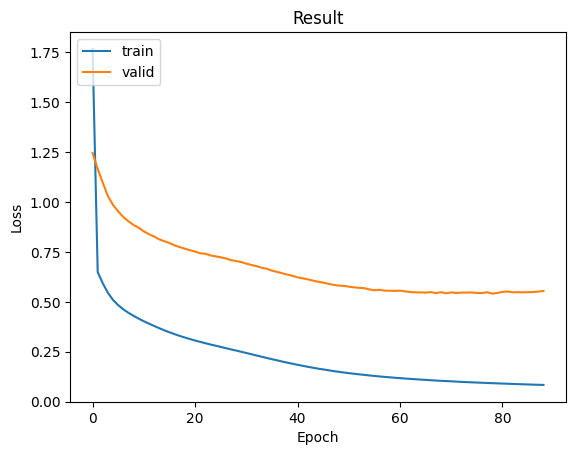

In [7]:
epochs = 100                             # 訓練次數
early_stopping = 10                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                 # 最佳的Loss
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss = train(epoch)
    valid_loss = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(encoder.state_dict(), 'e' + model_path)
        torch.save(decoder.state_dict(), 'd' + model_path)
        print(f'Saving Model With Loss {best_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f}' , end='| ')
    print(f'Valid Loss: {valid_loss:.5f}' , end='| ')
    print(f'Best Loss: {best_loss:.5f}', end='\n\n')


if show_loss:
    show_training_loss(loss_record)

In [19]:
encoder = EncoderRNN(input_size = INPUT_DIM, hidden_size = 128).to(device)
decoder = AttnDecoderRNN(hidden_size = 128, output_size = OUTPUT_DIM).to(device)
encoder.load_state_dict(torch.load('e' + model_path))
decoder.load_state_dict(torch.load('d' + model_path))

input_tensor = x_valid[0].to(device)
with torch.no_grad():
    encoder_outputs, encoder_hidden = encoder(input_tensor.unsqueeze(0))
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)
    
    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
        if idx.item() == EOS_IDX:
            break
        decoded_words.append(idx)
encoder_text = " ".join([en_vocab.lookup_token(i) for i in input_tensor if i!= PAD_IDX])
decoder_text = " ".join([fr_vocab.lookup_token(i) for i in decoded_words])
print("EN:", encoder_text)
print("FR:", decoder_text)

EN: she went shopping with him last monday . <EOS>
FR: Elle est partie faire des courses avec lui , un jour .


C:\Users\user\AppData\Local\Temp\ipykernel_17060\2325208752.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
C:\Users\user\AppData\Local\Temp\ipykernel_17060\2325208752.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' '))


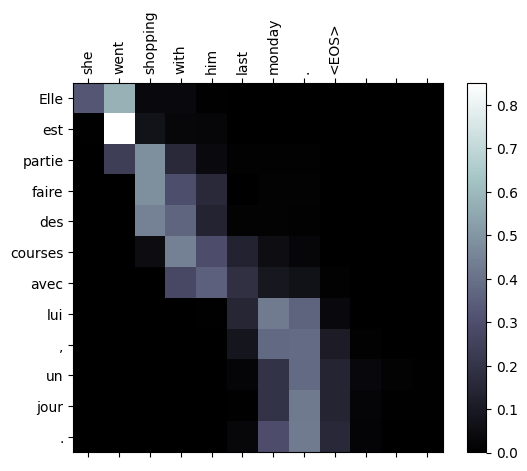

In [37]:
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

showAttention(encoder_text, decoder_text, decoder_attn[0,:len(decoded_words),:len(decoded_words)])